In [25]:
import sys, platform, pkgutil

print("Python:", sys.version)
print("Platform:", platform.platform())

need = []
for m in ["numpy","pandas","matplotlib","PIL","cv2","sklearn"]:
    ok = pkgutil.find_loader(m) is not None
    print(f"Package '{m}':", "OK" if ok else "MISSING")
    if not ok: need.append(m)
if need:
    print("\nThiếu package:", need)
    print("Cài nhanh bằng:")
    print("  pip install numpy pandas matplotlib pillow opencv-python scikit-learn")
else:
    print("\n✅ Môi trường OK.")

Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
Package 'numpy': OK
Package 'pandas': OK
Package 'matplotlib': OK
Package 'PIL': OK
Package 'cv2': OK
Package 'sklearn': OK

✅ Môi trường OK.


In [26]:
import os, glob, random, tarfile, pickle
from PIL import Image, ImageOps
import numpy as np, pandas as pd

IMG_DIR = "data/images"

def find_images(root):
    exts = (".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff")
    return [p for p in glob.glob(os.path.join(root,"**","*"), recursive=True)
            if p.lower().endswith(exts)]

images = find_images(IMG_DIR) if os.path.isdir(IMG_DIR) else []
print("Ảnh tìm thấy:", len(images))

if len(images) == 0:
    CANDIDATES = ["cifar-10-python.tar.gz","./cifar-10-python.tar.gz","../cifar-10-python.tar.gz"]
    tar_path = next((c for c in CANDIDATES if os.path.exists(c)), None)
    if tar_path is None:
        raise FileNotFoundError("Không có ảnh và không tìm thấy CIFAR-10.")
    out_root = os.path.join("data","images","cifar10_demo")
    os.makedirs(out_root, exist_ok=True)
    saved = 0
    with tarfile.open(tar_path,"r:gz") as tf:
        members=[m for m in tf.getmembers() if "data_batch" in m.name]
        for m in members:
            f=tf.extractfile(m); data=pickle.load(f,encoding="bytes")
            X=data[b"data"]; Y=data[b"labels"]
            for i in range(X.shape[0]):
                img=X[i].reshape(3,32,32).transpose(1,2,0)
                Image.fromarray(img).save(os.path.join(out_root,f"img_{saved:05d}.png"))
                saved+=1
                if saved>=300: break
            if saved>=300: break
    IMG_DIR=out_root; images=find_images(IMG_DIR)
    print(f"✅ Bung {saved} ảnh demo vào: {out_root}")

assert len(images)>0, "Không tìm thấy ảnh!"
random.seed(42); np.random.seed(42)
print("Ví dụ 5 ảnh:", images[:5])

Ảnh tìm thấy: 400
Ví dụ 5 ảnh: ['data/images\\cifar10\\0\\img_00000.png', 'data/images\\cifar10\\0\\img_00002.png', 'data/images\\cifar10\\0\\img_00029.png', 'data/images\\cifar10\\0\\img_00048.png', 'data/images\\cifar10\\0\\img_00052.png']


In [27]:
import time, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.dpi"]=120

TARGET_SIZES=[(128,128),(224,224)]
PAD_COLOR=(0,0,0)

def letterbox_resize(img, size=(224,224), color=(0,0,0)):
    w,h=img.size; sw,sh=size
    scale=min(sw/w, sh/h)
    nw,nh=int(w*scale), int(h*scale)
    img=img.resize((nw,nh), Image.BILINEAR)
    canvas=Image.new("RGB", size, color)
    canvas.paste(img,((sw-nw)//2,(sh-nh)//2))
    return canvas

def normalize_01(a): return a.astype(np.float32)/255.
def normalize_m11(a): return a.astype(np.float32)/127.5-1.

def standardize_dataset(X):
    flat=X.reshape(len(X),-1)
    scaler=StandardScaler()
    flat_std=scaler.fit_transform(flat)
    return flat_std.reshape(X.shape), scaler.mean_, scaler.scale_

def process_batch(paths,size=(224,224),max_n=10):
    sel=paths if len(paths)<=max_n else random.sample(paths,max_n)
    rgb_u8,gray_u8=[],[]
    t0=time.time()
    for p in sel:
        im=Image.open(p).convert("RGB")
        imr=letterbox_resize(im,size=size,color=PAD_COLOR)
        rgb_u8.append(np.asarray(imr))
        gray_u8.append(np.asarray(ImageOps.grayscale(imr)))
    t_resize=time.time()-t0
    Xrgb_u8=np.stack(rgb_u8); Xg_u8=np.stack(gray_u8)
    Xrgb_01=normalize_01(Xrgb_u8); Xrgb_m11=normalize_m11(Xrgb_u8)
    Xrgb_std,mu,sd=standardize_dataset(Xrgb_01.copy())
    return {"rgb_u8":Xrgb_u8,"gray_u8":Xg_u8,
            "rgb_01":Xrgb_01,"rgb_m11":Xrgb_m11,
            "rgb_std":Xrgb_std,"size":size,"t":t_resize,"paths":sel}

packs={sz:process_batch(images, size=sz, max_n=10) for sz in TARGET_SIZES}
print("✅ Xử lý xong 10 ảnh mẫu cho 2 kích thước.")


✅ Xử lý xong 10 ảnh mẫu cho 2 kích thước.


In [28]:
os.makedirs("outputs/processed_128", exist_ok=True)
os.makedirs("outputs/processed_224", exist_ok=True)

def save_processed(pack, outdir):
    for i,img in enumerate(pack["rgb_01"]):
        out_path=os.path.join(outdir,f"img_{i:02d}.png")
        Image.fromarray((img*255).astype(np.uint8)).save(out_path)
    print(f"✅ Đã lưu {len(pack['rgb_01'])} ảnh vào {outdir}")

save_processed(packs[(128,128)], "outputs/processed_128")
save_processed(packs[(224,224)], "outputs/processed_224")


✅ Đã lưu 10 ảnh vào outputs/processed_128
✅ Đã lưu 10 ảnh vào outputs/processed_224


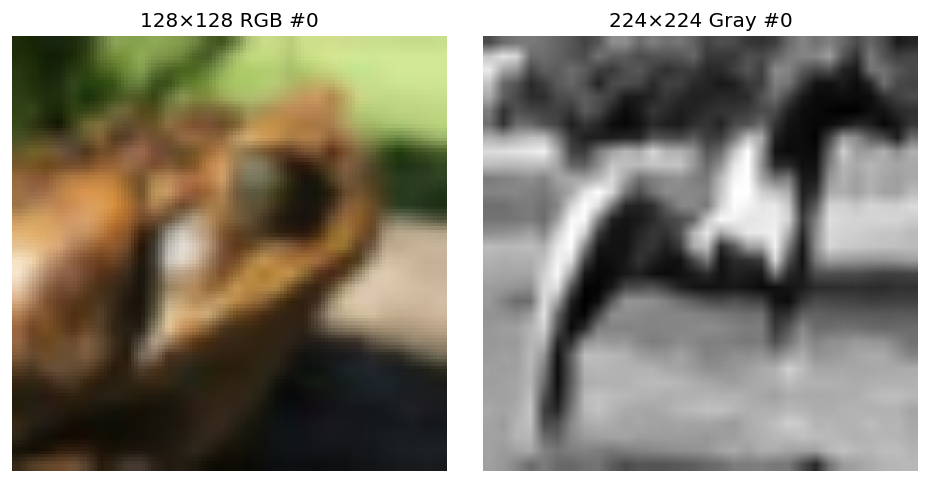

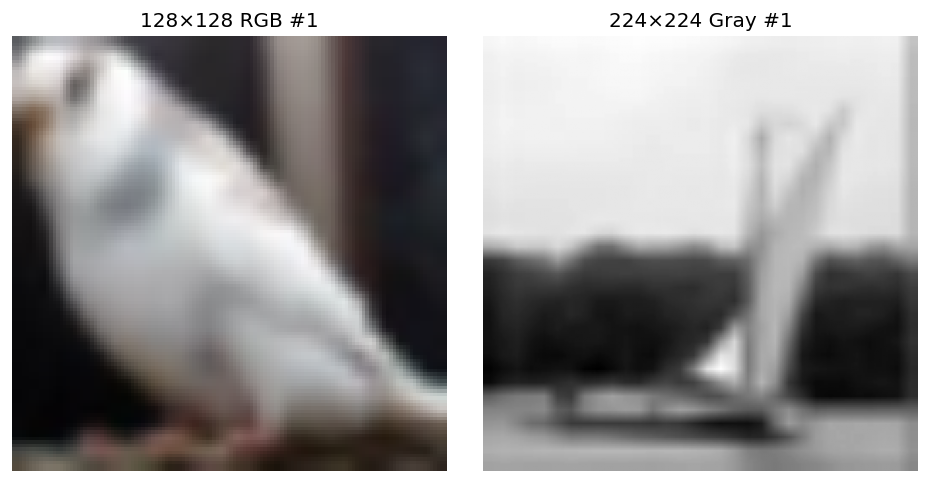

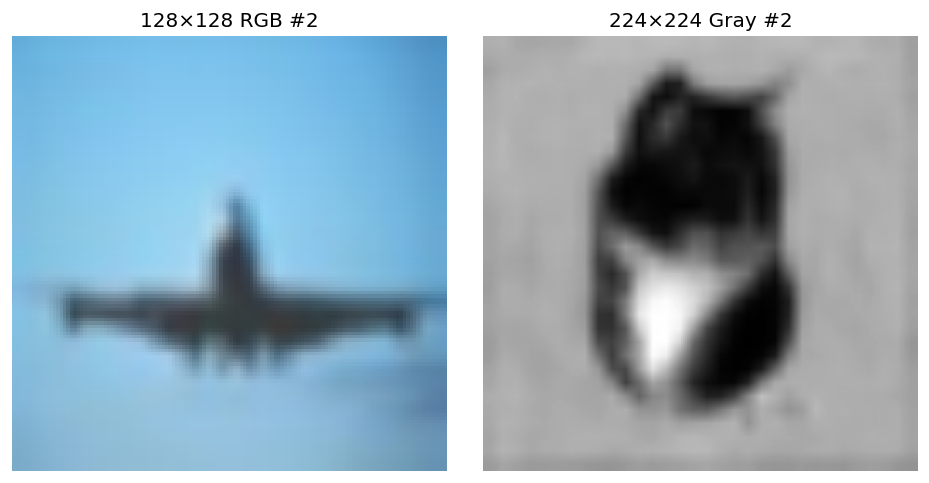

In [29]:
def show_examples(packs, idx_list=range(3)):
    for idx in idx_list:
        fig=plt.figure(figsize=(8,4))
        ax=plt.subplot(1,2,1); ax.imshow(packs[(128,128)]["rgb_u8"][idx]); ax.set_title(f"128×128 RGB #{idx}"); ax.axis("off")
        ax=plt.subplot(1,2,2); ax.imshow(packs[(224,224)]["gray_u8"][idx], cmap="gray"); ax.set_title(f"224×224 Gray #{idx}"); ax.axis("off")
        plt.tight_layout(); plt.show()
show_examples(packs, range(3))


In [30]:
rows=[]
for (w,h),pack in packs.items():
    N,H,W,C=pack["rgb_u8"].shape
    pixels=H*W
    rows.append({
        "Kích thước":f"{H}×{W}",
        "Số ảnh":N,
        "Pixels/ảnh":pixels,
        "RAM (MB)":round(pack["rgb_u8"].nbytes/1e6,2),
        "Thời gian resize (s)":round(pack["t"],3),
        "Tỉ lệ so 128×128":round(pixels/(128*128),2)
    })
pd.DataFrame(rows)


,Kích thước,Số ảnh,Pixels/ảnh,RAM (MB),Thời gian resize (s),Tỉ lệ so 128×128
0,128×128,10,16384,0.49,0.008,1.00
1,224×224,10,50176,1.51,0.000,3.06


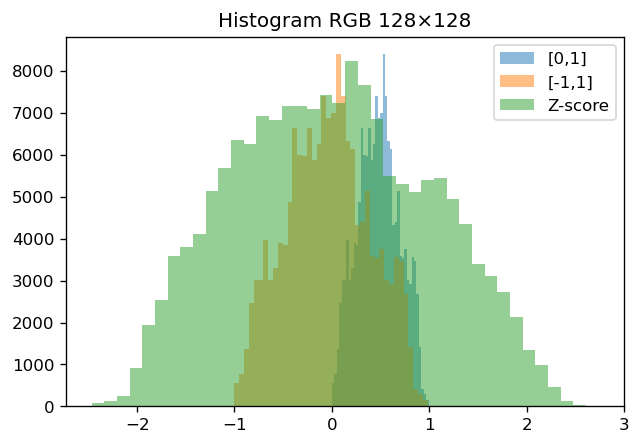

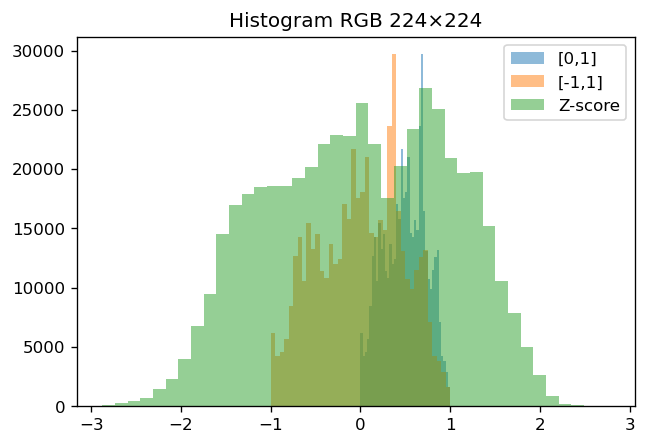

In [31]:
def plot_hist(pack):
    arr01=pack["rgb_01"][:,:,:,0].ravel()
    arrm11=pack["rgb_m11"][:,:,:,0].ravel()
    arrstd=pack["rgb_std"][:,:,:,0].ravel()
    plt.figure(figsize=(6,4))
    plt.hist(arr01,bins=40,alpha=0.5,label="[0,1]")
    plt.hist(arrm11,bins=40,alpha=0.5,label="[-1,1]")
    plt.hist(arrstd,bins=40,alpha=0.5,label="Z-score")
    plt.legend(); plt.title(f"Histogram RGB {pack['size'][0]}×{pack['size'][1]}"); plt.show()

plot_hist(packs[(128,128)])
plot_hist(packs[(224,224)])


In [32]:
def colorfulness(img):
    R,G,B = img[:,:,0], img[:,:,1], img[:,:,2]
    rg=np.abs(R-G); yb=np.abs(0.5*(R+G)-B)
    return np.sqrt(rg.std()**2 + yb.std()**2) + 0.3*np.sqrt(rg.mean()**2 + yb.mean()**2)

def entropy(gray):
    hist,_=np.histogram(gray.ravel(), bins=256, range=(0,255), density=True)
    hist=hist[hist>0]
    return -(hist*np.log2(hist)).sum()

rows=[]
for sz in [(128,128),(224,224)]:
    p=packs[sz]
    cf=[colorfulness(p["rgb_u8"][i]) for i in range(10)]
    en=[entropy(p["gray_u8"][i]) for i in range(10)]
    rows.append({"Kích thước":f"{sz[0]}×{sz[1]}","Colorfulness":np.mean(cf),"Entropy Gray":np.mean(en)})
pd.DataFrame(rows)


,Kích thước,Colorfulness,Entropy Gray
0,128×128,142.708899,7.136287
1,224×224,147.088601,7.338685


In [33]:
# SAVE 10 GRAYSCALE IMAGES (128 & 224)
import os
from PIL import Image
import numpy as np

os.makedirs("outputs/gray_128", exist_ok=True)
os.makedirs("outputs/gray_224", exist_ok=True)

def save_gray_pack(pack, outdir, limit=10):
    n = min(limit, pack["gray_u8"].shape[0])
    for i in range(n):
        g = pack["gray_u8"][i]               # uint8 (H,W)
        Image.fromarray(g).save(os.path.join(outdir, f"gray_{i:02d}.png"))
    print(f"✅ Saved {n} grayscale images to: {outdir}")

save_gray_pack(packs[(128,128)], "outputs/gray_128", limit=10)
save_gray_pack(packs[(224,224)], "outputs/gray_224", limit=10)


✅ Saved 10 grayscale images to: outputs/gray_128
✅ Saved 10 grayscale images to: outputs/gray_224


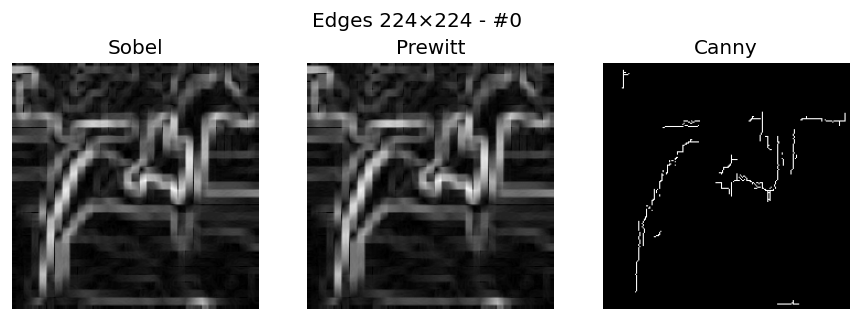

,Kích thước,Edge Density
0,128×128,0.022437
1,224×224,0.004438


In [34]:
import cv2 as cv

def prewitt(g):
    kx=np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    ky=np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    gx=cv.filter2D(g,cv.CV_32F,kx)
    gy=cv.filter2D(g,cv.CV_32F,ky)
    mag=np.sqrt(gx**2+gy**2)
    return np.uint8(255*mag/mag.max())

def sobel(g):
    sx=cv.Sobel(g,cv.CV_32F,1,0,ksize=3)
    sy=cv.Sobel(g,cv.CV_32F,0,1,ksize=3)
    mag=np.sqrt(sx**2+sy**2)
    return np.uint8(255*mag/mag.max())

def canny(g): return cv.Canny(g,80,160)

def show_edges(pack, idx=0):
    g=pack["gray_u8"][idx]
    sob,spr,can=sobel(g),prewitt(g),canny(g)
    fig,ax=plt.subplots(1,3,figsize=(9,3))
    for a,img,t in zip(ax,[sob,spr,can],["Sobel","Prewitt","Canny"]):
        a.imshow(img,cmap="gray"); a.set_title(t); a.axis("off")
    plt.suptitle(f"Edges {pack['size'][0]}×{pack['size'][1]} - #{idx}")
    plt.show()

show_edges(packs[(224,224)],0)

# edge density
rows=[]
for sz in [(128,128),(224,224)]:
    p=packs[sz]
    val=[]
    for i in range(10):
        g=p["gray_u8"][i]; e=canny(g)
        val.append(e.mean()/255)
    rows.append({"Kích thước":f"{sz[0]}×{sz[1]}","Edge Density":np.mean(val)})
pd.DataFrame(rows)


In [35]:
# SAVE 10 EDGE MAPS (Sobel / Prewitt / Canny) for 128 & 224
import os, numpy as np, cv2 as cv
from PIL import Image

# (Re)define edge functions in case this cell runs independently
def prewitt(gray_u8):
    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float32)
    ky = np.array([[ 1,1,1],[ 0,0,0],[-1,-1,-1]], dtype=np.float32)
    gx = cv.filter2D(gray_u8, cv.CV_32F, kx)
    gy = cv.filter2D(gray_u8, cv.CV_32F, ky)
    mag = np.sqrt(gx*gx + gy*gy)
    return np.uint8(255 * (mag / (mag.max() + 1e-6)))

def sobel(gray_u8):
    sx = cv.Sobel(gray_u8, cv.CV_32F, 1, 0, ksize=3)
    sy = cv.Sobel(gray_u8, cv.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(sx*sx + sy*sy)
    return np.uint8(255 * (mag / (mag.max() + 1e-6)))

def canny(gray_u8, t1=80, t2=160):
    return cv.Canny(gray_u8, t1, t2)

def save_edges_for_pack(pack, root_out, limit=10):
    # make folders
    d_sobel   = os.path.join(root_out, "sobel")
    d_prewitt = os.path.join(root_out, "prewitt")
    d_canny   = os.path.join(root_out, "canny")
    for d in (d_sobel, d_prewitt, d_canny):
        os.makedirs(d, exist_ok=True)

    n = min(limit, pack["gray_u8"].shape[0])
    for i in range(n):
        g = pack["gray_u8"][i]  # uint8 (H,W)

        e_sob = sobel(g)
        e_pre = prewitt(g)
        e_can = canny(g)

        Image.fromarray(e_sob).save(os.path.join(d_sobel,   f"edge_sobel_{i:02d}.png"))
        Image.fromarray(e_pre).save(os.path.join(d_prewitt, f"edge_prewitt_{i:02d}.png"))
        Image.fromarray(e_can).save(os.path.join(d_canny,   f"edge_canny_{i:02d}.png"))

    print(f"✅ Saved {n} edge triplets to: {root_out} (sobel/prewitt/canny)")

# 128×128
save_edges_for_pack(packs[(128,128)], "outputs/edges_128", limit=10)
# 224×224
save_edges_for_pack(packs[(224,224)], "outputs/edges_224", limit=10)


✅ Saved 10 edge triplets to: outputs/edges_128 (sobel/prewitt/canny)
✅ Saved 10 edge triplets to: outputs/edges_224 (sobel/prewitt/canny)


In [36]:
cmp=pd.DataFrame([
    {"Tiêu chí":"Chi phí tính toán","128×128":"Thấp","224×224":"Cao (~3×)","Chuẩn hoá":"[0,1]/[-1,1]"},
    {"Tiêu chí":"Chi tiết hình nhỏ","128×128":"Dễ mất","224×224":"Giữ tốt hơn","Chuẩn hoá":"ImageNet mean/std"},
    {"Tiêu chí":"Bộ nhớ","128×128":"Batch lớn","224×224":"Batch nhỏ","Chuẩn hoá":"[0,1]"},
    {"Tiêu chí":"Model nhỏ","128×128":"Phù hợp","224×224":"Quá tải","Chuẩn hoá":"[-1,1]"},
    {"Tiêu chí":"Transfer Learning","128×128":"Resize được","224×224":"Chuẩn","Chuẩn hoá":"ImageNet"},
]).set_index("Tiêu chí")
display(cmp)

print("""
=== PHÂN TÍCH ===
- 128×128 nhanh, phù hợp thí nghiệm nhỏ; 224×224 giữ chi tiết cho mô hình lớn.
- [0,1] và [-1,1] phù hợp CNN cơ bản; mean/std dùng khi fine-tune backbone.
- Entropy & Edge 224 cao hơn → nhiều chi tiết sáng–tối và biên hơn.
- Histogram cho thấy Z-score ổn định nhất.
- Khuyến nghị: dùng 128 khi kiểm thử nhanh; 224 khi báo cáo cuối / transfer.
""")


,128×128,224×224,Chuẩn hoá
Tiêu chí,,,
Chi phí tính toán,Thấp,Cao (~3×),"[0,1]/[-1,1]"
Chi tiết hình nhỏ,Dễ mất,Giữ tốt hơn,ImageNet mean/std
Bộ nhớ,Batch lớn,Batch nhỏ,"[0,1]"
Model nhỏ,Phù hợp,Quá tải,"[-1,1]"
Transfer Learning,Resize được,Chuẩn,ImageNet



=== PHÂN TÍCH ===
- 128×128 nhanh, phù hợp thí nghiệm nhỏ; 224×224 giữ chi tiết cho mô hình lớn.
- [0,1] và [-1,1] phù hợp CNN cơ bản; mean/std dùng khi fine-tune backbone.
- Entropy & Edge 224 cao hơn → nhiều chi tiết sáng–tối và biên hơn.
- Histogram cho thấy Z-score ổn định nhất.
- Khuyến nghị: dùng 128 khi kiểm thử nhanh; 224 khi báo cáo cuối / transfer.

